In [1]:
!wget -O database.zip https://humanheart-project.creatis.insa-lyon.fr/database/api/v1/collection/637218c173e9f0047faa00fb/download
!unzip database.zip

--2023-12-10 19:19:38--  https://humanheart-project.creatis.insa-lyon.fr/database/api/v1/collection/637218c173e9f0047faa00fb/download
Resolving humanheart-project.creatis.insa-lyon.fr (humanheart-project.creatis.insa-lyon.fr)... 195.220.108.28
Connecting to humanheart-project.creatis.insa-lyon.fr (humanheart-project.creatis.insa-lyon.fr)|195.220.108.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘database.zip’

database.zip            [               <=>  ]   2.28G  17.6MB/s    in 1m 58s  

2023-12-10 19:21:38 (19.8 MB/s) - ‘database.zip’ saved [2452589021]

Archive:  database.zip
 extracting: ACDC/database/training/patient015/MANDATORY_CITATION.md  
 extracting: ACDC/database/training/patient015/patient015_frame10_gt.nii.gz  
 extracting: ACDC/database/training/patient015/patient015_frame10.nii.gz  
 extracting: ACDC/database/training/patient015/patient015_frame01_gt.nii.gz  
 extracting: ACDC/database/training/pat

In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 15.6 MB/s eta 0:00:00


In [3]:
# Test code for loading one file from .nii to numpy array

import nibabel as nib
import numpy as np
from scipy.ndimage import affine_transform

# Specify the path to the input .nii.gz file
input_nii_gz_file = 'ACDC/database/training/patient025/patient025_frame01.nii.gz'

# Load the NIfTI file
nifti_image = nib.load(input_nii_gz_file)

# Access the data and header information
nifti_data = nifti_image.get_fdata()
header = nifti_image.header

# Access the shape of the data (dimensions) like this:
data_shape = nifti_data.shape

# Access the header information, such as the voxel sizes:
voxel_sizes = header.get_zooms()

affine_matrix = nifti_image.affine
inverse_affine = np.linalg.inv(affine_matrix)
inverse_affine_short = inverse_affine[:3,:3]
scaled_data = affine_transform(nifti_data, inverse_affine_short, output_shape=(216, 304, 8))

# Print some information for demonstration
print(f"Data Shape: {data_shape}")
print(f"Voxel Sizes: {voxel_sizes}")

print(f"affine shape: {affine_matrix.shape}")
print(f"affine: {affine_matrix}")


print(f"Inverse affine shape: {inverse_affine.shape}")
print(f"Inverse affine: {inverse_affine}")

print(f"Scled data shape: {scaled_data.shape}")
print(f"Scled data: {scaled_data}")

print(f"Data shape: {nifti_data.shape}")
print(f"Data: {nifti_data}")


Data Shape: (256, 256, 9)
Voxel Sizes: (1.3671875, 1.3671875, 10.0)
affine shape: (4, 4)
affine: [[-1. -0.  0.  0.]
 [-0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
Inverse affine shape: (4, 4)
Inverse affine: [[-1. -0. -0. -0.]
 [-0. -1. -0. -0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
Scled data shape: (216, 304, 8)
Scled data: [[[ 3.46019510e-17 -4.30666498e-18 -2.19931908e-19 ...  9.00630937e-21
   -7.04425354e-21 -2.00511898e-21]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[ 0.0000

Text(0.5, 0.98, 'Center slices for EPI image')

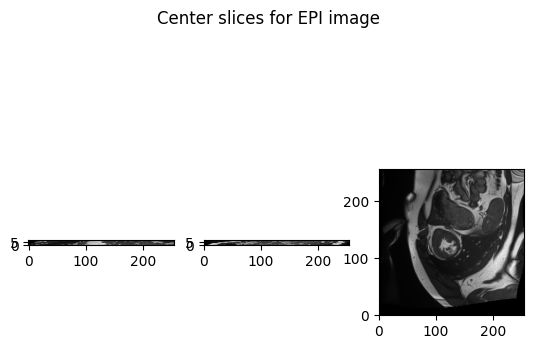

In [4]:
# Test code for data exploration, visualization

import matplotlib.pyplot as plt

def show_slices(slices):
   #Function to display row of image slices
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = nifti_data[110, :, :]
slice_1 = nifti_data[:, 150, :]
slice_2 = nifti_data[:, :, 6]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")


In [5]:
# Go through every folder and save the files into input-output numpy arrays

import os
import numpy as np
import nibabel as nib
from scipy.ndimage import affine_transform
from sklearn.model_selection import train_test_split

# Specify the path to the main folder containing 'test' and 'train' subfolders.
main_folder = 'ACDC/database'

# Initialize empty lists to store the data
input = []
output = []

#Function to load nifti image
def load_images(file_path):
  img = nib.load(file_path).get_fdata()
  return img

# Function to check if a file should be ignored
def should_ignore(file_name):
    return file_name == 'MANDATORY_CITATION.md'

# Iterate through 'test' and 'train' folders
for folder_name in ['testing', 'training']:
    if not should_ignore(folder_name):
      folder_path = os.path.join(main_folder, folder_name)
      patient_folders = os.listdir(folder_path)

      # Iterate through patient folders
      for patient_folder in patient_folders:
        if not should_ignore(patient_folder):
          patient_path = os.path.join(folder_path, patient_folder)
          files = os.listdir(patient_path)

          # Iterate through files in each patient folder
          for file_name in files:
            file_path = os.path.join(patient_path, file_name)

            if file_name.endswith('.nii.gz') & ('4d' not in file_name):
              #Separate the gt and non-gt files
              if 'gt' in file_name:
                gt_img = load_images(file_path)
                output.append([folder_name, gt_img])
              else:
                img = load_images(file_path)
                input.append([folder_name, img])

input_array = np.array(input)
output_array = np.array(output)

<ipython-input-5-88a13b6a0418>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_array = np.array(input)
<ipython-input-5-88a13b6a0418>:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output_array = np.array(output)


In [6]:
print(f"input shape: {input_array.shape}")
print(f"output shape: {output_array.shape}")
print(f"input folders: {input_array[:10,0]}")
print(f"input data: {input_array[:3,1]}")
print(f"output data: {output_array[:3,1]}")

input shape: (300, 2)
output shape: (300, 2)
input folders: ['testing' 'testing' 'testing' 'testing' 'testing' 'testing' 'testing'
 'testing' 'testing' 'testing']
input data: [array([[[ 0., 18.,  0., ...,  0.,  0.,  0.],
         [ 0., 18.,  0., ...,  0.,  0.,  0.],
         [ 0., 16.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0., 17., 12., ...,  0.,  0.,  0.],
         [21., 17., 12., ...,  0.,  0.,  0.],
         [23., 17., 12., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [11.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0., 17., 12., ...,  0.,  0.,  0.],
         [24., 17., 13., ...,  0.,  0.,  0.],
         [28., 19., 12., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.

In [7]:
from sklearn.model_selection import train_test_split

print(f"Input array shape: {input_array.shape}")

input_train = input_array[np.where(input_array[:, 0] == 'training')]
output_train = output_array[np.where(output_array[:, 0] == 'training')]

print(f"Input train shape: {input_train.shape}")
print(f"Output train shape: {output_train.shape}")

input_test = input_array[np.where(input_array[:, 0] == 'testing')]
output_test = output_array[np.where(output_array[:, 0] == 'testing')]
input_val, input_test, output_val, output_test = train_test_split(input_test, output_test, train_size = 0.6, shuffle = False)

print(f"Input validation shape: {input_val.shape}")
print(f"Output validation shape: {output_val.shape}")
print(f"Input test shape: {input_test.shape}")
print(f"Output test shape: {output_test.shape}")

Input array shape: (300, 2)
Input train shape: (200, 2)
Output train shape: (200, 2)
Input validation shape: (60, 2)
Output validation shape: (60, 2)
Input test shape: (40, 2)
Output test shape: (40, 2)


In [8]:
# NEW PADDING


import numpy as np

# Find the largest shape among all the arrays
largest_input_shape = np.max([arr.shape for _, arr in input_array], axis=0)
largest_output_shape = np.max([arr.shape for _, arr in output_array], axis=0)
print(largest_input_shape, largest_output_shape)

# Function to pad and process a batch of arrays
def process_batch(array, largest_shape, batch_size):
    padded_arrays = []
    for i in range(0, len(array), batch_size):
        batch = array[i:i + batch_size]
        batch_padded = []
        for name, arr in batch:
            max_shape = np.maximum(largest_shape, arr.shape)
            pad_width = [(0, max_dim - curr_dim) for max_dim, curr_dim in zip(max_shape, arr.shape)]
            padded_arr = np.pad(arr, pad_width, mode='constant')
            batch_padded.append((name, padded_arr))
        padded_arrays.extend(batch_padded)
    return padded_arrays

[428 512  21] [428 512  21]


In [9]:
input_array.shape

(300, 2)

In [10]:
input_array[0,1].shape

(216, 256, 11)

In [11]:
import numpy as np

# Assuming input_array has text in the first column and 3D images in the second column
# Function to slice 3D images along the third axis and create 2D images
def slice_3d_images(input_array):
    sliced_images = []
    for text, image_3d in input_array:
        for i in range(image_3d.shape[2]):
            image_2d = image_3d[:, :, i].astype('float16')
            sliced_images.append(image_2d)
    return np.array(sliced_images)

In [12]:
# Slice 3D images to get 2D images
# Slice 3D images to get 2D images
sliced_input_train = slice_3d_images(input_train)
sliced_input_val = slice_3d_images(input_val)
sliced_input_test = slice_3d_images(input_test)

sliced_output_train = slice_3d_images(output_train)
sliced_output_val = slice_3d_images(output_val)
sliced_output_test = slice_3d_images(output_test)

print(sliced_input_train.shape)
print(sliced_input_val.shape)
print(sliced_input_test.shape)
print(sliced_output_train.shape)
print(sliced_output_val.shape)
print(sliced_output_test.shape)

<ipython-input-11-234c5cfe96c0>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sliced_images)


(1902,)
(642,)
(434,)
(1902,)
(642,)
(434,)


In [13]:
sliced_input_train = sliced_input_train[:200]
sliced_output_train = sliced_output_train[:200]
sliced_input_val = sliced_input_val[:80]
sliced_output_val = sliced_output_val[:80]
sliced_input_test = sliced_input_test[:40]
sliced_output_test = sliced_output_test[:40]

print(sliced_input_train.shape)
print(sliced_input_val.shape)
print(sliced_input_test.shape)
print(sliced_output_train.shape)
print(sliced_output_val.shape)
print(sliced_output_test.shape)

(200,)
(80,)
(40,)
(200,)
(80,)
(40,)


In [14]:
sliced_inputs_all = np.concatenate((sliced_input_train, sliced_input_val, sliced_input_test))
print(f"sliced_inputs_all shape: {sliced_inputs_all.shape}")

sliced_inputs_all shape: (320,)


In [15]:
max_width = max(image.shape[1] for image in sliced_inputs_all)
max_height = max(image.shape[0] for image in sliced_inputs_all)

print(f"Max width: {max_width}, Max height: {max_height}")

Max width: 256, Max height: 256


In [16]:
# Round up the maximum height to be divisible by 32
padded_height = ((max_height - 1) // 32 + 1) * 32
print(f"Padded height (to be divisible by 32): {padded_height}")

Padded height (to be divisible by 32): 256


In [17]:
# Pad each 2D image to match the maximum width and height
padded_inputs = []
for image in sliced_input_train:
    pad_width = ((0, padded_height - image.shape[0]), (0, max_width - image.shape[1]))
    padded_image = np.pad(image, pad_width, mode='constant')
    padded_inputs.append(padded_image)

# Convert the list of padded images to a NumPy array
padded_input_train = np.array(padded_inputs)

# Now padded_images_array contains all the 2D images padded to the desired dimensions
print(padded_input_train.shape)  # The shape will be (total_2d_images, padded_height, padded_width)

(200, 256, 256)


In [18]:
# Pad each 2D image to match the maximum width and height
padded_inputs = []
for image in sliced_output_train:
    pad_width = ((0, padded_height - image.shape[0]), (0, max_width - image.shape[1]))
    padded_image = np.pad(image, pad_width, mode='constant')
    padded_inputs.append(padded_image)

# Convert the list of padded images to a NumPy array
padded_output_train = np.array(padded_inputs)

# Now padded_images_array contains all the 2D images padded to the desired dimensions
print(padded_output_train.shape)

(200, 256, 256)


In [19]:
# Pad each 2D image to match the maximum width and height
padded_inputs = []
for image in sliced_input_val:
    pad_width = ((0, padded_height - image.shape[0]), (0, max_width - image.shape[1]))
    padded_image = np.pad(image, pad_width, mode='constant')
    padded_inputs.append(padded_image)

# Convert the list of padded images to a NumPy array
padded_input_val = np.array(padded_inputs)

# Now padded_images_array contains all the 2D images padded to the desired dimensions
print(padded_input_val.shape)

(80, 256, 256)


In [20]:
# Pad each 2D image to match the maximum width and height
padded_inputs = []
for image in sliced_output_val:
    pad_width = ((0, padded_height - image.shape[0]), (0, max_width - image.shape[1]))
    padded_image = np.pad(image, pad_width, mode='constant')
    padded_inputs.append(padded_image)

# Convert the list of padded images to a NumPy array
padded_output_val = np.array(padded_inputs)

# Now padded_images_array contains all the 2D images padded to the desired dimensions
print(padded_output_val.shape)

(80, 256, 256)


In [21]:
# Pad each 2D image to match the maximum width and height
padded_inputs = []
for image in sliced_input_test:
    pad_width = ((0, padded_height - image.shape[0]), (0, max_width - image.shape[1]))
    padded_image = np.pad(image, pad_width, mode='constant')
    padded_inputs.append(padded_image)

# Convert the list of padded images to a NumPy array
padded_input_test = np.array(padded_inputs)

# Now padded_images_array contains all the 2D images padded to the desired dimensions
print(padded_input_test.shape)

(40, 256, 256)


In [22]:
# Pad each 2D image to match the maximum width and height
padded_inputs = []
for image in sliced_output_test:
    pad_width = ((0, padded_height - image.shape[0]), (0, max_width - image.shape[1]))
    padded_image = np.pad(image, pad_width, mode='constant')
    padded_inputs.append(padded_image)

# Convert the list of padded images to a NumPy array
padded_output_test = np.array(padded_inputs)

# Now padded_images_array contains all the 2D images padded to the desired dimensions
print(padded_output_test.shape)

(40, 256, 256)


In [23]:
array_x_shape=padded_output_test.shape[1]
array_y_shape=padded_output_test.shape[2]

In [24]:
# Find the largest shape among all the arrays
largest_input_shape = np.max([arr.shape for _, arr in input_array], axis=0)
largest_output_shape = np.max([arr.shape for _, arr in output_array], axis=0)

print(largest_input_shape, largest_output_shape)

[428 512  21] [428 512  21]


In [25]:
# Find the smallest shape among all the arrays
smallest_input_shape = np.min([arr.shape for _, arr in input_array], axis=0)
smallest_output_shape = np.min([arr.shape for _, arr in output_array], axis=0)

print(smallest_input_shape, smallest_output_shape)

[154 154   6] [154 154   6]


In [26]:
batch_size=16

In [27]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=c63e77843b7a09c6ec40a0d3614ca53d11edac60156b41c16e752831e231d8ed
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=cf0a4a5bab6e8da63547a230382fec381446ae701886d8e26ad5e056a1f2f2d1
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn.functional as F
import numpy as np
from torchmetrics import Dice
from segmentation_models_pytorch.losses import DiceLoss

class ResNetPretrainedModel(nn.Module):
    def __init__(self, num_classes=4, device="cuda:0"):
        super(ResNetPretrainedModel, self).__init__()
        # Load the pretrained ResNet model
        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

        # Modify the first convolutional layer to accept 1 channel
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Modify the final fully connected layer for the number of classes
        resnet.fc = nn.Linear(resnet.fc.in_features, num_classes * array_x_shape * array_y_shape)  # Adjusted for one-hot encoding

        self.resnet = resnet
        self.num_classes = num_classes
        self.device = device
        self.to(device)  # Move the model to the specified device

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(-1, array_x_shape, array_y_shape, self.num_classes)
        return x

    def training_step(self, batch):
        inputs, targets = batch
        outputs = self.forward(inputs)

        loss = self.calculate_loss(outputs, targets)
        return loss

    def on_train_epoch_end(self, train_loss):
        print(f'Train Loss: {train_loss}')

    def test_step(self, batch):
        inputs, targets = batch
        outputs = self.forward(inputs)

        loss = self.calculate_loss(outputs, targets)
        return {"test_loss": loss}

    def calculate_loss(self, outputs, targets):
        # Apply argmax along the last dimension
        targets = torch.argmax(targets, dim=3)
        predictions = F.softmax(outputs, dim=3).permute(0,3,1,2)

        # Convert to floating-point dtype
        predictions_float = predictions.float().requires_grad_()
        targets_float = targets.long()

        # Initialize the Dice metric
        dice_metric = DiceLoss(mode='multiclass', classes=[0,1,2,3], ignore_index=0)

        # Compute the Dice loss
        dice_loss = dice_metric(predictions_float, targets_float)

        return dice_loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=5e-2)

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader

    def test_dataloader(self):
        return test_loader


class CustomDataset(Dataset):
    def __init__(self, inputs, labels, num_classes=4):
        self.inputs = inputs
        self.labels = labels
        self.num_classes = num_classes

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_data = self.inputs[idx]
        label_data = self.labels[idx]

        if not torch.is_tensor(input_data):
            input_data = torch.from_numpy(input_data).float()

        if not torch.is_tensor(label_data):
            label_data = torch.from_numpy(label_data).long()

        return input_data, label_data

"""class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        # Apply argmax along the last dimension
        targets = torch.argmax(targets, dim=3)
        predictions = torch.argmax(predictions, dim=3)

        # Convert to floating-point dtype
        targets = targets.float().requires_grad_()
        predictions = predictions.float().requires_grad_()

        # Calculate intersection and union
        intersection = (predictions * targets).sum(dim=(1, 2))
        union = predictions.sum(dim=(1, 2)) + targets.sum(dim=(1, 2))

        # Calculate Dice coefficient
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Calculate Dice loss
        loss = 1.0 - dice.mean()

        return loss"""

# Normalize the inputs to the range [0, 1]
padded_input_train_normalized = (padded_input_train - np.min(padded_input_train)) / (np.max(padded_input_train) - np.min(padded_input_train))
padded_input_val_normalized = (padded_input_val - np.min(padded_input_val)) / (np.max(padded_input_val) - np.min(padded_input_val))
padded_input_test_normalized = (padded_input_test - np.min(padded_input_test)) / (np.max(padded_input_test) - np.min(padded_input_test))

# Add a channel dimension to the input data
padded_input_train_normalized = padded_input_train_normalized[:, np.newaxis, :, :]
padded_input_val_normalized = padded_input_val_normalized[:, np.newaxis, :, :]
padded_input_test_normalized = padded_input_test_normalized[:, np.newaxis, :, :]

# One-hot encode the labels
padded_output_train_one_hot = F.one_hot(torch.from_numpy(padded_output_train).long(), num_classes=4).float()
padded_output_val_one_hot = F.one_hot(torch.from_numpy(padded_output_val).long(), num_classes=4).float()
padded_output_test_one_hot = F.one_hot(torch.from_numpy(padded_output_test).long(), num_classes=4).float()

# Stack the datasets
train_dataset = CustomDataset(padded_input_train_normalized, padded_output_train_one_hot)
val_dataset = CustomDataset(padded_input_val_normalized, padded_output_val_one_hot)
test_dataset = CustomDataset(padded_input_test_normalized, padded_output_test_one_hot)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

# Initialize the model
model = ResNetPretrainedModel(device="cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training loop
max_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# Add early stopping
best_val_loss = float('inf')
patience = 8  # Number of epochs to wait for improvement
wait_count = 0

for epoch in range(max_epochs):
    model.train()
    total_train_loss = 0.0
    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = model.calculate_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_loader)
    model.on_train_epoch_end(average_train_loss)

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for batch in val_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = model.calculate_loss(outputs, targets)
            val_loss += loss.item()

        average_val_loss = val_loss / len(val_loader)

        # Early stopping and model checkpointing
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            wait_count = 0

            # Save the model checkpoint
            checkpoint_path = "best_model.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }, checkpoint_path)
        else:
            wait_count += 1
            if wait_count >= patience:
                print("Early stopping. No improvement in validation loss.")
                break
    print("Validation Loss:", average_val_loss)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Train Loss: 0.47320438348329985
Validation Loss: 0.48489995002746583
Train Loss: 0.4573316826270177
Validation Loss: 0.4829194724559784
Train Loss: 0.4572833570150229
Validation Loss: 0.48515948057174685
Train Loss: 0.4559464752674103
Validation Loss: 0.48504499197006223
Train Loss: 0.4549961113012754
Validation Loss: 0.48277862668037413
Train Loss: 0.4567850369673509
Validation Loss: 0.48033217191696165
Train Loss: 0.4559686550727257
Validation Loss: 0.48438650369644165
Train Loss: 0.4557679066291222
Validation Loss: 0.48066715002059934
Train Loss: 0.45367114131267255
Validation Loss: 0.48107707500457764
Train Loss: 0.4541224676829118
Validation Loss: 0.4832025170326233
Train Loss: 0.4535062358929561
Validation Loss: 0.48049052357673644
Train Loss: 0.4527541926273933
Validation Loss: 0.4823127746582031
Train Loss: 0.4530666126654698
Validation Loss: 0.4827267825603485
Train Loss: 0.45302449281399065
Early stopping. No improvement in validation loss.


# **We could not even overfit our basic model with so little data, as can be seen from the fact that the following test is from the training data set**

We will continue to debug the source of this issue.

In [29]:
import torch

# Assuming 'model' is the trained model
model.eval()  # Set the model to evaluation mode

# Get one instance from the training dataset
sample_index = 11  # You can choose any index here
input_data, target_labels = train_dataset[sample_index]

print(input_data.shape)
print(target_labels.shape)

# Add a batch dimension to the input data
input_data = input_data.unsqueeze(0)

# Move input data and model to CPU
input_data = input_data.to("cpu")
model = model.to("cpu")

# Make predictions
with torch.no_grad():
    predictions = model(input_data)

# Post-process predictions if needed (e.g., apply softmax)
# For example, assuming softmax is applied along the class dimension (dim=1)
predictions = torch.softmax(predictions, dim=1)

# Convert predictions and target labels to numpy arrays for easier comparison
predictions_np = predictions.numpy()
predictions_np = np.squeeze(predictions_np, axis=0)
target_labels_np = target_labels.numpy()

# Print or visualize the results
print("Predictions:")
print(predictions_np.shape)
print("Target Labels:")
print(target_labels_np.shape)

# Find the index of the maximum value along the class dimension for predictions and target labels
predictions_indices = np.argmax(predictions_np, axis=2)
target_labels_indices = np.argmax(target_labels_np, axis=2)

# Print or visualize the results
print("Predictions (Indices):")
print(predictions_indices)
print("Target Labels (Indices):")
print(target_labels_indices)


# Find the index of the maximum value along the class dimension for predictions and target labels
predictions_indices = np.argmax(predictions_np, axis=2)
target_labels_indices = np.argmax(target_labels_np, axis=2)

# Calculate accuracy for each index
correct_predictions = (predictions_indices == target_labels_indices).sum()
total_pixels = np.prod(target_labels_indices.shape)  # Total number of pixels

# Calculate accuracy
accuracy = correct_predictions / total_pixels
print(f"Accuracy: {accuracy}")


torch.Size([1, 256, 256])
torch.Size([256, 256, 4])
Predictions:
(256, 256, 4)
Target Labels:
(256, 256, 4)
Predictions (Indices):
[[1 2 1 ... 2 3 3]
 [0 3 1 ... 3 1 1]
 [1 3 0 ... 2 0 2]
 ...
 [2 2 2 ... 2 2 3]
 [1 1 1 ... 3 1 2]
 [0 1 0 ... 2 1 1]]
Target Labels (Indices):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Accuracy: 0.4143829345703125
